In [1]:
#%pip uninstall importlib_metadata -y
#%pip install importlib_metadata --force-reinstall

In [2]:
#%pip install keras

In [3]:
#%env SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True

In [4]:
#%pip install --force-reinstall -v "wfdb==1.3.9"

In [5]:
#%pip install --force-reinstall -v "wfdb==4.1.2"

In [6]:
# %pip install wfdb
# %pip install tqdm


In [7]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import wfdb
import numpy as np
from tqdm import tqdm

1. Data Collection:
·Datasets Used:
·CHF-RR Dataset: Congestive heart failure RR interval database. It comprised patients with heart failure. This dataset contained records of 29 patients from CHF201 to CHF229.
·NSR-RR Dataset: Normal sinus rhythm RR interval database. This dataset had 54 normal sinus rhythm recordings ranging in age from 28 to 76. Records from NSR001 through NSR054 of 54 patients were available.
·Both datasets were provided by PhysioBank.
2. Data Preprocessing:
·Conversion: Datasets were converted to CSV files or directly imported into Python.
·Library Used: The wfdblibrary was employed to read, write, and process WFDB signals and annotations. The library can be accessed at wfdb library.
·Grouping Approach: Among various grouping methods for the TSC algorithm, intervals were chosen over whole series. Data was normalized and divided into intervals of 5sec, 20sec, 40sec, 60sec, and 80sec.
·Data Formatting: Data was formatted into univariate UCR time series.
3. Data Augmentation:
·Data Augmentation Strategy: To combat issues of underfitting and overfitting, data augmentation was mentioned as a strategy. However, specific augmentation techniques were not detailed in the provided information.

# Downloading Data

In [8]:
dbs = wfdb.get_dbs()
display(dbs)

[['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database [sample excluded record]'],
 ['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['chfdb', 'BIDMC Congestive Heart Failure Database'],
 ['bidmc', 'BIDMC PPG and Respiration Dataset'],
 ['bpssrat', 'Blood Pressure in Salt-Sensitive Dahl Rats'],
 ['capslpdb', 'CAP Sleep Database'],
 ['crisdb', 'CAST RR Interval Sub-Study Database'],
 ['cves', 'Cerebral Vasoregulation in Elderly with Stroke'],
 ['challenge/2009/test-set-a', 'Challenge 2009 Test Set A'],
 ['challenge/2009/test-set-b', 'Challenge 2009 Test Set B'],
 ['challenge/2010/set-a', 'Challenge 2010 Training Set A'],
 ['challenge/2010/set-b', 'Challenge 2010 Test Set B'],
 ['challenge/2010/set-c', 'Challenge 2010 Test Set C'],
 ['challenge/2011/sim', 'Challenge 2011 Pilot Set'],
 ['challenge/2011/set-a', 'Challenge 2011 Training Set A'],
 ['challenge/2011/set-b', 'Chall

In [9]:
def download(database):
    cwd = os.getcwd()
    dl_dir = os.path.join(cwd, database)
    wfdb.dl_database(database, dl_dir=dl_dir)
    display(os.listdir(dl_dir))

In [10]:
# download('nsrdb')

In [11]:
# download('chfdb')

# Converting Data

In [12]:
def wfdb_to_dataframe(record):
    #df = record.to_dataframe()
    df = pd.DataFrame(record.p_signal, columns=record.sig_name)
    return df
 
def load_record(uri):
    record = wfdb.rdrecord(uri)
    return wfdb_to_dataframe(record)

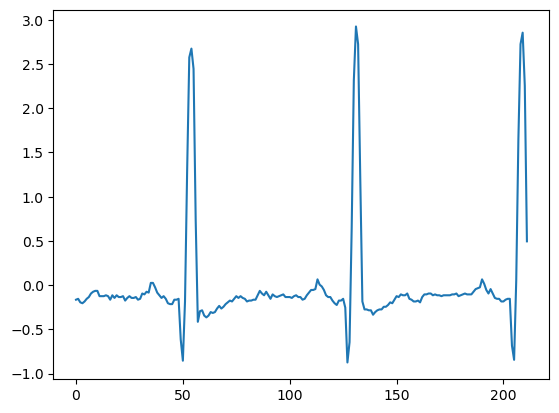

In [13]:
a = load_record('nsrdb/16265')
plt.plot(a['ECG1'][:212])
plt.show()

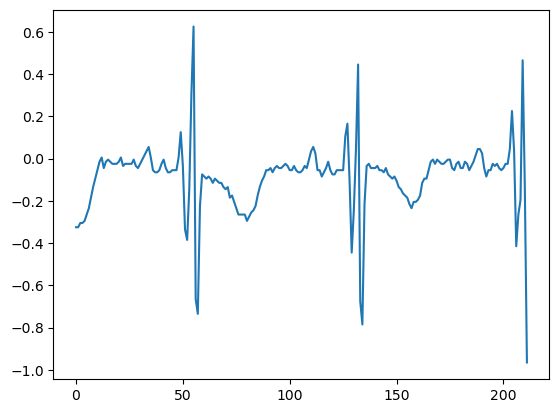

In [14]:
plt.plot(a['ECG2'][:212])

In [15]:
load_record('chfdb/chf03')

,ECG1,ECG2
0,-0.320,-0.305
1,-0.305,-0.285
2,-0.295,-0.260
3,-0.320,-0.230
4,-0.320,-0.215
...,...,...
17998843,-0.200,-0.345
17998844,-0.190,-0.325
17998845,-0.165,-0.300
17998846,-0.165,-0.295


In [16]:
nsrdb_list = glob.glob("nsrdb/*.hea")
len(nsrdb_list)

18

In [17]:
chfdb_list = glob.glob("chfdb/*.hea")
len(chfdb_list)

15

In [18]:
def create_db(file_list, record_class, clip_duration=60, sampling_rate=250):
    clip_len = sampling_rate * clip_duration
    num_channels = len(load_record(file_list[0].removesuffix('.hea')).columns)
    total_clips = sum(len(load_record(file_path.removesuffix('.hea'))) // clip_len for file_path in file_list)

    # Preallocate a NumPy array for all clips
    all_clips = np.empty((total_clips, clip_len * num_channels + 1))  # +1 for the class label

    clip_index = 0
    for file_path in file_list:
        record_df = load_record(file_path.removesuffix('.hea'))
        num_clips = len(record_df) // clip_len

        for i in range(num_clips):
            clip = record_df.iloc[i * clip_len : (i + 1) * clip_len].values.flatten()
            all_clips[clip_index, :-1] = clip  # Fill all but last column with clip data
            all_clips[clip_index, -1] = record_class  # Last column is the class label
            clip_index += 1

    # Convert the NumPy array directly to a DataFrame
    column_names = [f't{i}' for i in range(clip_len * num_channels)] + ['class']
    df_clips = pd.DataFrame(all_clips, columns=column_names)

    return df_clips


In [19]:
record_len = 190_800

In [20]:
nsrdb_df = create_db(nsrdb_list, 0)
nsrdb_df.shape

(13432, 30001)

In [21]:
chfdb_df = create_db(chfdb_list, 1)
chfdb_df.shape

(17922, 30001)

In [22]:
full_df = pd.concat([nsrdb_df, chfdb_df],axis=0, ignore_index=True, sort=False)
full_df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t29991,t29992,t29993,t29994,t29995,t29996,t29997,t29998,t29999,class
0,-0.165,-0.325,-0.155,-0.325,-0.195,-0.305,-0.205,-0.305,-0.185,-0.295,...,-0.035,-0.025,-0.065,-0.015,-0.005,-0.015,0.015,-0.055,0.025,0.0
1,-0.055,0.005,-0.115,-0.015,-0.115,-0.015,-0.125,-0.005,-0.145,-0.035,...,-0.055,-0.185,-0.045,-0.125,-0.015,-0.105,0.005,-0.135,0.025,0.0
2,-0.115,0.025,-0.015,-0.025,-0.055,-0.045,-0.115,-0.085,-0.145,-0.095,...,0.015,-0.155,-0.085,-0.195,-0.095,-0.325,-0.055,-0.285,-0.115,0.0
3,-0.285,-0.055,-0.375,-0.045,-0.215,-0.125,-0.325,-0.075,-0.355,-0.115,...,-0.205,0.055,-0.215,0.085,-0.225,0.015,-0.245,-0.025,-0.265,0.0
4,-0.095,-0.185,-0.055,-0.165,-0.085,-0.115,-0.175,-0.105,-0.135,0.035,...,-0.025,-0.145,-0.055,-0.075,-0.075,-0.025,-0.105,-0.025,-0.145,0.0


# Split Data

In [23]:
y_df = full_df.pop("class")
x_df = full_df

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.30, random_state=42)

In [25]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [26]:
print("Training Data:", X_train.shape)
print("Validation Data:", X_validate.shape)
print("Testing Data:", X_test.shape)

Training Data: (17557, 30000)
Validation Data: (4390, 30000)
Testing Data: (9407, 30000)


# Model

In [27]:
input_shape = (X_train.shape[1], 1, )

The first convolutional layer will consist of 20 filters, followed by a max-pooling layer of length 2.
 
The second convolutional layer will have 80 filters with a max-pooling layer of length 4.
 
There will be 32 neurons used in the fully connected convolution layers to feed into the softmax classification layer.

In [28]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv1D(20, 5),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(80, 5),
        tf.keras.layers.MaxPooling1D(4),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1, activation='sigmoid'),  # Sigmoid for binary classification
    ]
)


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29996, 20)         120       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14998, 20)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 14994, 80)         8080      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3748, 80)          0         
 g1D)                                                            
                                                                 
 dense (Dense)               (None, 3748, 32)          2592      
                                                                 
 dense_1 (Dense)             (None, 3748, 32)          1

# Model Training

In [30]:
batch_size = 32
epochs = 30

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/30
124/124 [==============================] - 220s 2s/step - loss: 0.4317 - accuracy: 0.8015 - val_loss: 0.3774 - val_accuracy: 0.8267
Epoch 2/30
124/124 [==============================] - 225s 2s/step - loss: 0.3676 - accuracy: 0.8554 - val_loss: 0.3537 - val_accuracy: 0.8539
Epoch 3/30
 22/124 [====>.........................] - ETA: 3:00 - loss: 0.3644 - accuracy: 0.8630

# Model Evaluation

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])